# 🧬 **ИИ в биологии** 🧬

<a href="https://ibb.co/Cs0GsQD"><img src="https://i.ibb.co/mFzWF4g/d3ccc3f8-69e2-428f-8ec4-896221936735.webp" alt="Scifi collage of AI in biology" border="0"></a>



# Искусственный интеллект в биологии
Добро пожаловать на практикум **Искусственный интеллект в биологии**! На этом занятии мы:
- Узнаем о некоторых основных областях применения искусственного интеллекта в биологических науках
- Рассмотрим роль ДНК и то, как обучаются языковые модели ДНК
- Извлекайте и исследуйте встраивания ДНК с использованием предварительно обученной современной языковой модели ДНК
- Погрузитесь в практическую задачу по моделированию последовательностей ДНК и их свойств

**Предварительные требования:**

1. Основы Python
2. BioPython не требуется

**Практический План:**

<div align="left">
<a href="https://ibb.co/jryGWdL"><img src="https://i.ibb.co/kS409ph/Screenshot-2024-07-23-at-21-48-22.png" alt="Screenshot-2024-07-23-at-21-48-22" width="400" border="0"></a>
</div>



**Перед началом работы:**

Для этого практического занятия вам нужно будет использовать графический процессор (GPU), чтобы ускорить обучение. Для этого перейдите в меню "Среда выполнения" в Colab, выберите "Сменить среду выполнения", а затем во всплывающем меню выберите "Графический процессор T4" в поле "Аппаратный ускоритель".


Мы также уже можем установить и импортировать все необходимые пакеты:

In [90]:
## Устанавливайте и импортируйте все необходимое, загружайте модели, загружайте данные.
# @title Установите и импортируйте необходимые пакеты. (Запустите Cell)
#%%capture

# Установки.
!pip install transformers datasets
!pip install biopython requests h5py
!pip install jax
!pip install flax

# Импорт.
import os
import random
import tqdm

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import flax.linen as nn
import optax
import torch


import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import Entrez, SeqIO

from sklearn.manifold import TSNE

from transformers import AutoTokenizer, AutoModelForMaskedLM


# Скачайте языковую модель ДНК и токенизатор.
tokenizer = AutoTokenizer.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species",
    trust_remote_code=True)

language_model = AutoModelForMaskedLM.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species",
    trust_remote_code=True)

# Загрузите предварительно извлеченные вложения для случайных строк ДНК.
ROOT_DIR = "https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2024/main/practicals/AI_for_Biology/data/"

import pandas as pd
dna_sequences = pd.read_csv(os.path.join(ROOT_DIR, "dna_sequences.csv"))
train_df = pd.read_feather(os.path.join(ROOT_DIR, "train_embeddings.feather"))
valid_df = pd.read_feather(os.path.join(ROOT_DIR, "valid_embeddings.feather"))

In [91]:
# @title Проверяет TPU / графический процессор. (Run Cell)
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")

Found 1 JAX devices of type cpu.



## 1. Применение ИИ в биологии

ИИ становится все более распространенным явлением в биологической области, и в последнее время были достигнуты некоторые действительно захватывающие успехи. Тем не менее, отрасль все еще находится в самом начале своего развития – это означает, что предстоит проделать много интересной работы, и это отличное время для участия!

Вот краткий обзор некоторых интересных недавних работ в области искусственного интеллекта в биологии в нескольких различных областях.


### Медицинская диагностика

Модеь классификации рака кожи, подобные этой, [от MIT](https://www.science.org/doi/10.1126/scitranslmed.abb3652) которая достигает результатов, сопоставимым с результатами сетрифицированных дерматологов:
<div align="center">
    <img src="https://wp.technologyreview.com/wp-content/uploads/2021/06/automated-melanoma-detection-small2.gif?w=400" alt="Automated Melanoma Detection GIF">
</div>


Модель сегментации и классификации заболеваний сетчатки [от DeepMind](https://www.nature.com/articles/s41591-018-0107-6) способна диагностировать многие офтальмологические заболевания с помощью 3D-сканирования сетчатки. Ее производительность аналогична лучшим специалистам по сетчатке и превосходит некоторых экспертов-людей:


<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cnyoA2T8BFZRBYWnUlYEtQ.gif" alt="Retinal scan segmentation gif">
</div>

[Модель SynthSR из Гарварда и Калифорнийского университета в Лос-Анджелесе](https://www.science.org/doi/10.1126/sciadv.add3607) позволяет проводить клиническую МРТ головного мозга с любым контрастом, ориентацией и разрешением и преобразовывать их в 3D-изображения высокого разрешения:

<div align="center">
    <img src="https://www.science.org/cms/10.1126/sciadv.add3607/asset/7a6c5ed9-af95-41d2-b888-2b5a653ea55b/assets/images/large/sciadv.add3607-f1.jpg" alt="SynthSR MRI scan model" width="400">
</div>



### Фармацевтика и разработка лекарственных средств

[Компания Exscientia](https://www.exscientia.com/) разработала первый препарат с искусственным интеллектом, который прошел клинические испытания (DSP-1181, направлен на лечение обсессивно-компульсивного расстройства).

Многие разработки лекарств с помощью искусственного интеллекта используют модели для прогнозирования того, насколько тесно небольшие молекулы будут связываться с различными участками белка-мишени, участвующего в данном заболевании:

<div align="center">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/03/bionemo_featured.jpeg" alt="general pocket showing" width="400">
</div>


[BenevolentAI](https://www.benevolent.com/about-us/sustainability/covid-19/) использовала искусственный интеллект для определения барицитиниба, первоначально препарата от артрита, в качестве потенциального средства лечения COVID-19 в течение 48 часов, используя свой график знаний.

<div align="center">
    <img src="https://www.benevolent.com/application/files/6616/7458/5885/Corona_Baricitinib.png" alt="BenevolentAI Baricitinib" width="400">
</div>

[Ссылка на видео на YouTube под названием "BenevolentAI · AI-Enabled Drug Discovery"(Открытие лекарств с поддержкой искусственного интеллекта)](https://www.youtube.com/watch?v=RPBDhogTIT0)

[Recursion Pharmaceuticals](https://www.recursion.com/) известна высокопроизводительным скринингом и оптимизацией и разработала передовые модели визуализации клеток:

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/0*yVLwEtfojWdnMZfA" alt="Recursion" width="800">
</div>


Они обучают модели предсказывать пропущенные пиксели в изображениях ячеек аналогично тому, как большие языковые модели предсказывают пропущенные или замаскированные слова в предложениях:

<div align="center">
    <img src="https://blogs.nvidia.com/wp-content/uploads/2024/05/Recursion-Phenom-AI-model-animation.gif" alt="Recursion" width="800">
</div>

Другие стартапы, занимающиеся глубоким обучением для открытия лекарств, включают Atomwise, insitro, Insilico Medicine, Deep Genomics и Deepcell.

Кроме того, крупные фармацевтические компании, такие как Illumina, GSK и Genentech, создали внутренние команды глубокого обучения и разработали влиятельные модели, такие как [SpliceAI](https://www.cell.com/cell/pdf/S0092-8674(18)31629-5.pdf)  (модель, которая понимает сплайсинг) и [PrimateAI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6237276/) (модель, которая предсказывает клинический эффект мутаций в белках), демонстрируя растущую интеграцию глубокого обучения в рабочие процессы биологии.



### Молекулярная биология

Модель [AlphaFold model by DeepMind](https://www.nature.com/articles/s41586-021-03819-2) от DeepMind произвела революцию в области прогнозирования структуры белка, получив широкое распространение и признание в научных кругах, биотехнологической и фармацевтической промышленности:

<div align="center">
    <img src="https://spectrum.ieee.org/media-library/two-examples-of-protein-targets-in-the-free-modelling-category-in-green-is-the-experimental-result-in-blue-is-the-computationa.gif?id=25559695&width=2400&height=1358" alt="AlphaFold predictions" width="800">
</div>

Исследователи из [EvolutionaryScale](https://www.evolutionaryscale.ai/blog/esm3-release) использовали свою модель ESM3 protein language для разработки нового флуоресцентного белка, который совершенно отличается от флуоресцентных белков, встречающихся в природе:

<div align="center">
    <img src="https://cdn.prod.website-files.com/6606dc3fd5f6645318003e20/667a5bb780d0ada7dc37d1c0_image%20(1).png" alt="ESM3" width="400">
</div>




### Экология и охрана природы

[Rainforest Connection (RFCx)](https://rfcx.org/)  - это инновационный проект, который размещает модифицированные смартфоны на деревьях, записывает аудио, а затем использует модели для идентификации различных видов, присутствующих в этом районе. Это помогает отслеживать биоразнообразие и выявлять незаконные действия, такие как лесозаготовки, в режиме реального времени.

<div align="center">
    <img src="https://www.huawei.com/~/media/CORPORATE/Images/case-studies/case1/photo-grid.jpg" alt="Rainforest connection setup" width="600">
</div>

<div align="center">
    <img src="https://cdn.ttgtmedia.com/visuals/LeMagIT/Forest1.png" alt="Rainforest connection audio" width="600">
</div>


[Проект CETI](https://www.projectceti.org/) (Инициатива по переводу китообразных) использует искусственный интеллект для анализа и декодирования звуков китов, чтобы понять их общение и поведение.

<div align="center">
    <img src="https://i0.wp.com/www.josephdelpreto.com/wp-content/uploads/2023/09/Project-CETI_s-Approach-_-Illustration-%C2%A9-2023-Alex-Boersma.jpg?resize=1024%2C912" alt="CETI whale" width="600">
</div>


В конкурсе Zindi под названием [Turtle Recall](https://zindi.africa/competitions/turtle-recall-conservation-challenge) пользователям предлагалось создать модель, которая могла бы идентифицировать отдельных морских черепах по рисункам чешуи на их головах, что могло бы помочь улучшить навыки общения с морскими черепахами:

<div align="center">
    <img src="https://lh3.googleusercontent.com/9J6DZgiuGyYr3N1DoJBmZMVpBkTlGOq19QUws7G2fbFcuHeIJKQ3plFh-R2xkxB1OpVaqZhcglM6hWWl5x7PuuxbtnDlIWlCgoCr0LGVM4S-loaj_Jc=w1232-rw" alt="Turtle recall" width="600">
</div>



### **Вопрос**: 
Какая из этих областей применения искусственного интеллекта в биологии кажется вам наиболее интересной?
1. 🏥 **Медицинская диагностика** 🏥
2. 💊 **Фармацевтической и разработке лекарств** 💊
3. 🧬 **Молекулярная Биология** 🧬
4. 🌳 **Экологии и охраны природы** 🌳
5. **Другое** (какое? :)

Учттывая мою специализацию, предположительно, молекулярка:)

### **Вопрос**: 
о какой еще интересной работе в области искусственного интеллекта в биологии вы знаете?

Поиск ро зависимых терминаторов в бактериальных геномных последовательнастях:))

### Дополнительная справочная информация

Эти примеры не являются исчерпывающими и приведены лишь для того, чтобы дать вам представление о некоторых современных приложениях искусственного интеллекта в биологии. Если вы хотите узнать больше об этой области, вот несколько интересных ресурсов для чтения:

- *Nature Communications* обзор 2022 года под названием ["Current progress and open challenges for applying deep learning across the biosciences"](https://www.nature.com/articles/s41467-022-29268-7)
- Немного более старая (2018) обзорная статья под названием [“Opportunities and obstacles for deep learning in biology and medicine”](https://royalsocietypublishing.org/doi/10.1098/rsif.2017.0387). Это число достигло более 2000 цитирований!
- ["Deep Learning for the Life Sciences"](https://www.oreilly.com/library/view/deep-learning-for/9781492039822/) 2019 O'Reilly книга, в которой излагаются практические идеи и приложения глубокого обучения в геномике, химии и биоинформатике.









## 2. Введение в ДНК


Мы надеемся, что этого введения было достаточно, чтобы вы заинтересовались приложениями глубокого обучения в биологии! В оставшейся части этого практического занятия давайте сами поработаем над ИИ в биологии по теме **ДНК**.

<div align="center">
    <img src="https://i.pinimg.com/originals/c7/90/76/c79076215950e968828f663e1b69fe67.gif" alt="DNA gif" width="200">
</div>


**ДНК - это молекула наследственности, основа всей жизни в том виде, в каком мы ее знаем**.

Впервые его структура была обнаружена в 1953 году, что стало поворотным моментом в биологических науках. Первый проект генома человека был опубликован в 2001 году, заложив основу для современной геномики.

Но эти даты совсем недавние, и хотя теперь мы знаем кое-что из "чего" генома, мы очень далеки от понимания того, "как" он на самом деле функционирует.

Например, мы знаем, что ДНК состоит из 4 разных "букв", а именно A (аденин), C (цитозин), G (гуанин) и T (тимин), и что геном человека состоит из 3,2 миллиарда букв, которые распределены по 23 парам хромосом. ДНК упаковывается различными способами, чтобы вписаться в клеточное ядро:

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*EUKrGpPzUAwp2sOOPZOcqA.jpeg" alt="DNA text" width="400">
</div>

Если бы мы открыли "книгу" генома человека, то увидели бы что-то вроде этого:

<div align="center">
    <img src="https://cms.wellcome.org/sites/default/files/styles/image_full_hi/public/WI_C0035768_GenomeEditing_20150902_News_600x600.jpg?itok=FCedpedU" alt="DNA text" width="400">
</div>

**Это может быть очень трудно интерпретировать**. И есть много ДНК для интерпретации – их достаточно, чтобы заполнить книжный шкаф, если напечатать их на разных томах:

<div align="center">
    <img src="https://live.staticflickr.com/3265/2569126918_b68047a65b_b.jpg" alt="DNA bookcase" width="400">
</div>


Вот некоторые из основных открытых вопросов, которые у нас есть о ДНК::
- Что делают 3,2 миллиарда букв в геноме человека? Все ли они биологически функциональны?
- Как каждая клетка в организме человека может иметь абсолютно одинаковый геном, но выполнять совершенно разные функции? Например, подумайте о том, насколько нейрон отличается от мышечной клетки.
- Мы знаем, что только приблизительно 2% ДНК в геноме кодирует белки, что делают остальные 98%?
- Как генетические вариации приводят к заболеваниям или к различиям, которые мы наблюдаем между людьми?

Подводя итог:

***"Геном человека" можно рассматривать как очень длинную книгу, слова в которой состоят из букв A, T, C и G. Модели глубокого обучения открывают большие перспективы для понимания генома благодаря их способности улавливать сигнал в больших, сложных и потенциально зашумленных данных.***

## Языковые модели ДНК

**Языковые модели ДНК (LMS)** очень похожи на большие языковые модели, с которыми вы, возможно, знакомы, такие как ChatGPT, Gemini, Claude и др. Вместо обучения на больших объемах текста на естественном языке, ДНК-фильмы обучаются на больших объемах последовательностей ДНК.

Как многие LLM, так и LM ДНК обучаются случайным образом **маскируя** некоторые токены в тексте, а затем заставляя модель предсказать, что это за токен:

<div align="center">
<a href="https://ibb.co/M9d9GM0"><img src="https://i.ibb.co/25J5sg4/Screenshot-2024-07-23-at-22-18-57.png" alt="Screenshot-2024-07-23-at-22-18-57" width="800" border="0"></a>
</div>

Точно так же, как магистры права изучают язык, который затем может быть полезен для многих последующих задач, 
Языковые модели ДНК могут улавливать сложные паттерны и структуры внутри ДНК, что делает их ценными для различных последующих геномных задач, таких как анализ мутаций и понимание регуляторных элементов.:

## Некоторые популярные модели языка ДНК

По мере того, как программы LLM становятся все более успешными, все больше и больше людей проявляют интерес к обучению моделям языка ДНК. Вот некоторые из наиболее известных:

- [DNABERT](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) (2021) - DNABERT адаптирует модель BERT, которая была весьма успешной в НЛП, для понимания последовательностей ДНК.
- [HyenaDNA](https://arxiv.org/abs/2306.15794) (2023) - Специализируется на длинных последовательностях ДНК, с контекстной длиной до 1 миллиона маркеров на уровне одного нуклеотида.
- [Nucleotide Transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1) (2023) - архитектура на основе трансформатора, специально разработанная для нуклеотидных последовательностей.

Некоторые люди также доработали существующие LLM на естественном языке для последовательностей ДНК, например [Mistral-DNA](https://github.com/raphaelmourad/Mistral-DNA).

Для практического применения мы будем использовать модель Nucleotide Transformer
(NT), потому что она довольно хороша, популярна и легко доступна на [Hugging Face platform 🤗](https://huggingface.co/).



## Модель нуклеотидного трансформатора (NT)

Nucleotide Transformer был обучен на 3202 различных геномах человека, а также на 850 геномах широкого спектра видов.Модель генерирует переносимые, зависящие от контекста представления последовательностей ДНК.

Еще несколько деталей о модели:
- NT - это архитектура преобразования только для кодировщика, обученная с использованием подхода BERT (маскирование частей последовательностей ДНК). Последовательности ДНК были помечены как 6-mers.
- Это неконтролируемая модель, но только ее представления соответствуют или превосходят специализированные методы в 11 из 18 задач прогнозирования, таких как предсказание того, содержит ли данный фрагмент ДНК определенные регуляторные элементы, известные как промоторы и энхансеры.
- Обучающие данные для версии NT `nucleotide-transformer-v2-50m-multi-species` были обучены в общей сложности на ** 174B нуклеотидах **, то есть примерно на **29B токенах**. Вот статистика для каждой группы организмов:

| Class                | Number of species  | Number of nucleotides (B) |
| ---------------------| -------------------| --------------------------|
| Bacteria             | 667                | 17.1                      |
| Fungi                | 46                 | 2.3                       |
| Invertebrate         | 39                 | 20.8                      |
| Protozoa             | 10                 | 0.5                       |
| Mammalian Vertebrate | 31                 | 69.8                      |
| Other Vertebrate     | 57                 | 63.4                      |

Доступны и другие, увеличенные версии модели Hugging Face [здесь](https://huggingface.co/collections/InstaDeepAI/nucleotide-transformer-65099cdde13ff96230f2e592). Мы используем здесь относительно небольшую модель по соображениям скорости.

## Изучение встраивания ДНК у разных видов

Давайте загрузим модель Nucleotide Transformer (NT) из HuggingFace и начнем с ней играть!

Мы уже загрузили токенизатор и модель в первую ячейку блокнота. Это и есть эти два объекта:

In [92]:
type(tokenizer)

transformers.models.esm.tokenization_esm.EsmTokenizer

In [93]:
type(language_model)

transformers_modules.InstaDeepAI.nucleotide-transformer-v2-50m-multi-species.ebe8e9ea00908a1e5a8f289d47d95bb09aac9f19.modeling_esm.EsmForMaskedLM


Давайте посмотрим, что эта модель узнала о ДНК разных видов. Мы можем взять случайные последовательности ДНК из разных видов, использовать модель для извлечения **встроенного** представления ДНК и посмотреть, имеют ли сходные виды тенденцию иметь ДНК с похожими представлениями.

Давайте составим список представляющих интерес видов:

In [94]:
organisms = [
    'Homo sapiens',  # Human
    'Pan troglodytes',  # Chimpanzee
    'Pan paniscus',     # Bonobo
    'Gorilla gorilla',  # Gorilla
    'Tursiops truncatus',  # Dolphin (bottlenose)
    'Hydrochoerus hydrochaeris',  # Capybara
    'Escherichia coli',  # E. coli bacteria
    'Lactobacillus acidophilus',  # Common probiotic bacterium
    'Salmonella enterica',  # Common foodborne pathogen
    'Pseudomonas aeruginosa',  # Bacterium found in soil and water
]

print(len(organisms))

10


Мы можем использовать Entrez Библиотеку Python для выполнения поиска в базе данных случайной строки ДНК для данного организма:

In [95]:
import os
#___________________________________________________________________________________ ПРЕДУПРЕЖДЕНИЕ, ТУТ Я ОТКЛЮЧИЛ ВСЮ БЕЗОПАСНОСТЬ СОЕДИНЕНИЯ
# Отключаем проверку HTTPS на уровне интерпретатора.
os.environ['PYTHONHTTPSVERIFY'] = '0'

import ssl
import urllib.request

# Создаем контекст с отключенной проверкой сертификатов.
ssl_context = ssl._create_unverified_context()
# Создаем HTTPSHandler с нашим контекстом.
https_handler = urllib.request.HTTPSHandler(context=ssl_context)
# Собираем новый opener и регистрируем его как глобальный.
opener = urllib.request.build_opener(https_handler)
urllib.request.install_opener(opener)

from Bio import Entrez, SeqIO

# Задаем контекст для Entrez.
Entrez.ssl_context = ssl_context
#___________________________________________________________________________________
organism = 'Homo sapiens'
gene = 'BRCA1'  # Пример названия гена.
Entrez.email = "pavel.bulyha@gmail.com"

# Формируем запрос к базе данных.
query = f'({gene}[Gene Name]) AND {organism}[Organism] AND "RefSeq"[filter]'

# Выполняем поиск записей.
handle = Entrez.esearch(db='nucleotide', term=query, retmax=10)
record = Entrez.read(handle)
handle.close()

# Выбираем случайную запись.
np.random.seed(42)
random_record_id = np.random.choice(record['IdList'])

# Получаем последовательность из выбранной записи.
handle = Entrez.efetch(
    db='nucleotide', 
    id=random_record_id, 
    rettype='fasta', 
    retmode='text'
)
seq_record = SeqIO.read(handle, 'fasta')
handle.close()

print(seq_record)
print("Поиск завершён")


ID: NM_001408451.1
Name: NM_001408451.1
Description: NM_001408451.1 Homo sapiens BRCA1 DNA repair associated (BRCA1), transcript variant 310, mRNA
Number of features: 0
Seq('GCTGAGACTTCCTGGACGGGGGACAGGCTGTGGGGTTTCTCAGATAACTGGGCC...CCA')
Поиск завершён


Мы можем легко извлечь цепочку ДНК из этой записи:

In [96]:
dna_sequence = str(seq_record.seq)
dna_sequence

'GCTGAGACTTCCTGGACGGGGGACAGGCTGTGGGGTTTCTCAGATAACTGGGCCCCTGCGCTCAGGAGGCCTTCACCCTCTGCTCTGGTTCATTGGAACAGAAAGAAATGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTAATGCTATGCAGAAAATCTTAGAGTGTCCCATCTGGAGCCTACAAGAAAGTACGAGATTTAGTCAACTTGTTGAAGAGCTATTGAAAATCATTTGTGCTTTTCAGCTTGACACAGGTTTGGAGTATGCAAACAGCTATAATTTTGCAAAAAAGGAAAATAACTCTCCTGAACATCTAAAAGATGAAGTTTCTATCATCCAAAGTATGGGCTACAGAAACCGTGCCAAAAGACTTCTACAGAGTGAACCCGAAAATCCTTCCTTGGAAACCAGTCTCAGTGTCCAACTCTCTAACCTTGGAACTGTGAGAACTCTGAGGACAAAGCAGCGGATACAACCTCAAAAGACGTCTGTCTACATTGAATTGGGATCTGATTCTTCTGAAGATACCGTTAATAAGGCAACTTATTGCAGTGTGGGAGATCAAGAATTGTTACAAATCACCCCTCAAGGAACCAGGGATGAAATCAGTTTGGATTCTGCAAAAAAGGCTGCTTGTGAATTTTCTGAGACGGATGTAACAAATACTGAACATCATCAACCCAGTAATAATGATTTGAACACCACTGAGAAGCGTGCAGCTGAGAGGCATCCAGAAAAGTATCAGGGTGAAGCAGCATCTGGGTGTGAGAGTGAAACAAGCGTCTCTGAAGACTGCTCAGGGCTATCCTCTCAGAGTGACATTTTAACCACTCAGCAGAGGGATACCATGCAACATAACCTGATAAAGCTCCAGCAGGAAATGGCTGAACTAGAAGCTGTGTTAGAACAGCATGGGAGCCAGCCTTCTAACAGCTACCCTTCCATCATAAGTGACTCTTCTGCCCTTGAGGACCTGCGAAATCCAG

Модель NT может быть использована для вычисления числового представления значения этой строки ДНК. Мы просто передадим строку ДНК в качестве входных данных, обозначим ее и извлекем окончательные активации скрытого слоя из модели:

In [100]:
# Tokenize the DNA sequence.
max_length = tokenizer.model_max_length

token_ids = tokenizer.batch_encode_plus(
  [dna_sequence], return_tensors='pt',
  padding='max_length', max_length=max_length,
  truncation=True)['input_ids']

token_ids

tensor([[   3, 3705,  608,  ...,    1,    1,    1]])

Вы можете видеть, что последовательность ДНК была маркирована и дополнена символом `1` до максимальной длины 2048:

In [101]:
len(token_ids[0])

2048

In [102]:
token_ids[0][-50:]  # Show the last 50 tokens.

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

Теперь давайте возьмем выходные данные модели с учетом этих входных данных ДНК:

In [103]:
attention_mask = token_ids != tokenizer.pad_token_id

torch_outs = language_model(
  token_ids,
  attention_mask=attention_mask,
  encoder_attention_mask=attention_mask,
  output_hidden_states=True,
)

Мы можем видеть, что присутствуют 13 различных выходных данных скрытых состояний, представляющих выходные данные из 13 различных уровней в модели:

In [104]:
len(torch_outs['hidden_states'])

13

Давайте возьмем конечное скрытое состояние с индексом `-1`, поскольку это, вероятно, будет информативным (но, возможно, не оптимально информативным для каждой задачи - мы могли бы попробовать предпоследнее скрытое состояние или предпоследнее третье и т.д.).:

In [105]:
embeddings = torch_outs['hidden_states'][-1].detach()
embeddings = np.squeeze(embeddings.numpy())
embeddings.shape

(2048, 512)

Мы можем видеть, что вложение представляет собой матрицу размером 2048 на 512. Это большая вычислительная матрица!

In [106]:
embeddings

array([[-0.11629012,  0.46589923,  0.1679897 , ..., -0.2522723 ,
        -0.12069149, -0.19459972],
       [-0.8165438 ,  0.35171723,  0.3231829 , ..., -0.32326648,
        -0.98214287, -0.2937013 ],
       [-0.09435398,  0.47468847,  0.05433575, ..., -0.02901587,
         0.3908945 ,  0.36394954],
       ...,
       [-0.72034293,  1.0877419 ,  0.32370812, ..., -0.10283032,
        -0.7627153 , -1.0481844 ],
       [-0.74054134,  1.0460615 ,  0.24285091, ..., -0.29076302,
        -0.85446316, -0.900694  ],
       [-0.9411088 ,  1.0188293 ,  0.21054266, ..., -0.44054663,
        -0.8289268 , -1.0524396 ]], shape=(2048, 512), dtype=float32)

В рамках этой большой матрицы чисел модель уловила некоторое представление о значении цепочки ДНК.

Напомним, что наша строка ДНК имела длину 2048 – это означает, что каждая позиция имеет свой собственный вектор вложения длиной 512, учитывающий контекст.

Мы могли бы визуализировать эту матрицу чисел, но это само по себе не имело бы особого смысла:


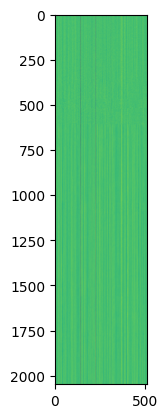

In [107]:
plt.imshow(embeddings)
plt.show()

Одним из распространенных способов обобщения подобного встраивания является вычисление **среднего значения встраивания** – мы можем взять среднее значение по пространственной оси и получить встраивание длиной 512, которое представляет всю последовательность ДНК.

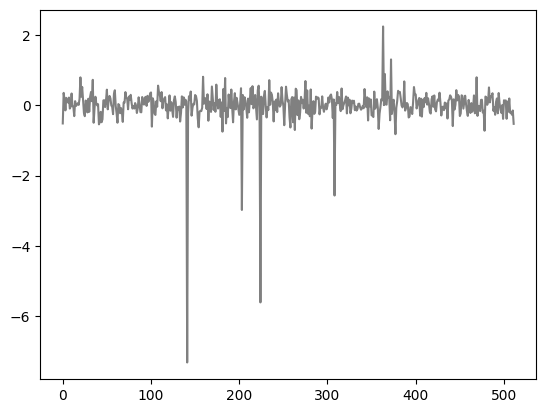

In [108]:
# Переместите ось, чтобы заставить вещание работать.
attention_mask = np.moveaxis(attention_mask.numpy(), 0, -1)

# Вычислить среднее встраивание.
mean_embeddings = np.sum(
    attention_mask * embeddings, axis=0) / np.sum(attention_mask)

plt.plot(mean_embeddings, color='grey')
plt.show()

**Приятно иметь возможность вот так сократить последовательность ДНК до 512 чисел, но все равно трудно по-настоящему понять, что означают эти числа.**

Ценность вложений последовательностей действительно проявляется, когда вы **сравниваете их друг с другом**. Итак, давайте напишем функцию `fetch_random_dna`, которая извлечет несколько случайных последовательностей ДНК для данного вида:

In [109]:
def fetch_random_dna(
  organism: str,
  min_length: int,
  max_length: int,
  num_sequences: int,
  max_attempts: int = 50) -> list[str]:
  """Извлеките определенное количество последовательностей ДНК заданной длины для определенного вида."""
  # Ищите нуклеотидные записи для организма, как мы делали раньше.
  handle = Entrez.esearch(
      db='nucleotide', term=f'{organism}[Organism]', retmax=max_attempts)
  record = Entrez.read(handle)
  handle.close()
  if not record['IdList']:
    return []

  # Мы можем собрать наши последовательности ДНК в этом списке.
  sequences = []
  attempts = 0

  while len(sequences) < num_sequences and attempts < max_attempts:
    random_record_id = random.choice(record['IdList'])
    handle = Entrez.efetch(
        db='nucleotide', id=random_record_id, rettype='fasta', retmode='text')
    try:
      seq_record = SeqIO.read(handle, 'fasta')
      handle.close()

      if len(seq_record.seq) >= min_length:
        seq = str(seq_record.seq)
        if len(seq) > max_length:
          seq = seq[:max_length]
        sequences.append(seq)

    # Обработайте случай, когда не было найдено ни одной действительной записи FASTA.
    except ValueError:
      handle.close()
    attempts += 1

  return sequences

Давайте воспользуемся этим, чтобы получить одну короткую последовательность ДНК для человека:

In [110]:
fetch_random_dna(
    organism='Homo sapiens', min_length=10, max_length=50, num_sequences=1)

['AATTTCGGAATTGCAGGCAGCGTCTCCTGAGGACAAGGGGAAAGCCGGTG']

Теперь мы можем легко использовать это для извлечения некоторых последовательностей ДНК для организмов из нашего списка выше. Код для этого будет выглядеть следующим образом:

In [142]:
NUM_SEQUENCES = 1
MIN_LENGTH = 100
MAX_LENGTH = 1000
random.seed(42)

first_organisms = organisms[0:3]

print(f'Выборка {NUM_SEQUENCES} случайной последовательности ДНК минимальной длины '
      f'{MIN_LENGTH} и максимальной длины {MAX_LENGTH} для {len(first_organisms)} '
      'организмов...\n')

dna_sequences_small = []
organism_labels = []

for organism in tqdm.tqdm(first_organisms, desc='Организмы'):
  print(organism, flush=True)
  sequences = fetch_random_dna(
      organism, min_length=MIN_LENGTH, max_length=MAX_LENGTH,
      num_sequences=NUM_SEQUENCES)
  dna_sequences_small += sequences
  organism_labels += [organism] * len(sequences)

dna_sequences_small = pd.DataFrame({'sequence': dna_sequences_small, 'organism': organism_labels})

Выборка 1 случайной последовательности ДНК минимальной длины 100 и максимальной длины 1000 для 3 организмов...



Организмы:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]

Homo sapiens


Организмы:  33%|████████████████████████▎                                                | 1/3 [00:01<00:03,  1.70s/it]

Pan troglodytes


Организмы:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:03<00:01,  1.54s/it]

Pan paniscus


Организмы: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


Но это займет несколько минут, если мы хотим получить, скажем, 20 последовательностей ДНК для каждого из 10 организмов, поэтому для скорости мы предварительно выбрали некоторые последовательности для удобства:

In [145]:
dna_sequences

,sequence,organism
0,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCT...,Homo sapiens
1,ATACTCTGGTTTCTCTTCAGATCGCATAAATCTTTCGCCTTTTACT...,Homo sapiens
2,NGCTTTGCGCAGTGGCAGTATCGTAGCCAATGAGGTCTATCCGAGG...,Homo sapiens
3,ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTG...,Homo sapiens
4,GGGAGGTTTCCTTGAAGCTTTCGTGCTGACCCTGTCCCTTTTTTTT...,Homo sapiens
...,...,...
195,CGGCGGAGATCTCGAACTACGTCAACATCCAGCGGAAGAAGAAGGT...,Pseudomonas aeruginosa
196,GCTTGCTCATCAGACACCTCTCTCACGGCGAGGATTCTCGCCTAAA...,Pseudomonas aeruginosa
197,ATGAGCGGCGTCGCCCGCGAGGCCATGGAGGACGTCGCGCCGGCGG...,Pseudomonas aeruginosa
198,ATGCTGATCCGCGCCGCAACCTCGACCCTGCTGGTGGTCGATATCC...,Pseudomonas aeruginosa


Мы можем использовать наш предыдущий код для извлечения средних последовательностей встраивания строк ДНК:

In [113]:
def _compute_mean_sequence_embeddings(
  dna_sequences: list[str],
  tokenizer: AutoTokenizer,
  model: AutoModelForMaskedLM):

  max_length = tokenizer.model_max_length
  tokens_ids = tokenizer.batch_encode_plus(
    dna_sequences, return_tensors="pt", padding="max_length",
    max_length=max_length)["input_ids"]

  # Вычислите вложения.
  attention_mask = tokens_ids != tokenizer.pad_token_id

  # Переместите модель и тензоры на графический процессор. (если не получится, останется на CPU)
  model = model.to("cuda" if torch.cuda.is_available() else "cpu")
  tokens_ids = tokens_ids.to("cuda" if torch.cuda.is_available() else "cpu")
  attention_mask = attention_mask.to("cuda" if torch.cuda.is_available() else "cpu")

  # По умолчанию PyTorch сохраняет график вычислений для обратного прохождения, но это
  # заполняет оперативную память, а нам это не нужно, поэтому мы отключаем это с помощью torch.no_grad() .
  with torch.no_grad():
    torch_outs = model(
      tokens_ids,
      attention_mask=attention_mask,
      encoder_attention_mask=attention_mask,
      output_hidden_states=True,
    )

  # Вычисление вложений последовательностей.
  embeddings = torch_outs['hidden_states'][-1].detach().cpu()

  # Добавьте ось встроенного измерения.
  attention_mask_cpu = torch.unsqueeze(attention_mask.cpu(), dim=-1)

  # Вычислите среднее значение вложений для каждой последовательности
  mean_sequence_embeddings = torch.sum(
    attention_mask_cpu * embeddings, axis=-2) / torch.sum(attention_mask_cpu, axis=1)

  return mean_sequence_embeddings.numpy()


def compute_mean_sequence_embeddings(
    dna_sequences: list[str],
    tokenizer: AutoTokenizer,
    model: AutoModelForMaskedLM,
    batch_size: int = 4) -> np.ndarray:
  """Вычисляет средние значения встраивания последовательностей для списка строк ДНК."""
  all_mean_embeddings = []

  for i in tqdm.tqdm(range(0, len(dna_sequences), batch_size)):
    batch_sequences = dna_sequences[i:i+batch_size]
    batch_mean_embeddings = _compute_mean_sequence_embeddings(
        batch_sequences, tokenizer, model)
    all_mean_embeddings.extend(batch_mean_embeddings)

  return np.vstack(all_mean_embeddings)


In [114]:
embeddings = compute_mean_sequence_embeddings(
    dna_sequences['sequence'], tokenizer, language_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:59<00:00,  5.99s/it]


Это дает нам встраивание длиной 512 для каждой из 200 строк ДНК:

In [115]:
embeddings.shape

(200, 512)

Было бы здорово визуализировать их. Но поскольку люди на самом деле не могут визуализировать объекты в 512-мерном пространстве, давайте сначала воспользуемся техникой уменьшения размерности, такой как tSNE, чтобы спроецировать данные до двух измерений. Это дает 2 числа для каждой исходной последовательности ДНК, которые все еще отражают некоторое представление о значении в ДНК:

In [116]:
# Определяем число физических ядер с помощью wmic или используем логические ядра, если не удалось.
import multiprocessing
try:
    output = subprocess.check_output(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        text=True
    ).strip()
    lines = output.splitlines()
    # Пропускаем заголовок и суммируем количество ядер по всем CPU.
    num_cores = sum(int(line.split(',')[-1]) for line in lines[1:] if line)
except Exception as e:
    num_cores = multiprocessing.cpu_count()

# Устанавливаем переменную окружения для Loky
os.environ["LOKY_MAX_CPU_COUNT"] = str(num_cores)
print("Using", num_cores, "CPU cores (LOKY_MAX_CPU_COUNT).")
#__________________________________________________________________________
tsne = TSNE(n_components=2, learning_rate='auto', random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

embeddings_tsne_df = pd.DataFrame(
    embeddings_tsne, columns=['first_dim', 'second_dim'])

embeddings_tsne_df['organism'] = dna_sequences['organism']
embeddings_tsne_df

Using 8 CPU cores (LOKY_MAX_CPU_COUNT).


,first_dim,second_dim,organism
0,-35.622070,96.967926,Homo sapiens
1,-54.250107,132.498474,Homo sapiens
2,-80.369370,120.909874,Homo sapiens
3,-9.819554,129.389542,Homo sapiens
4,-100.618370,109.416306,Homo sapiens
...,...,...,...
195,-85.745644,99.472870,Pseudomonas aeruginosa
196,35.117790,-114.008217,Pseudomonas aeruginosa
197,34.167030,-156.688278,Pseudomonas aeruginosa
198,61.588875,47.866882,Pseudomonas aeruginosa


Чтобы увидеть, объединяются ли сходные типы последовательностей ДНК, происходящие от сходных типов видов, мы можем пометить каждый маркер либо меткой его вида, либо более общей меткой, такой как "животное" или "растение", и изменить схему и раскрасить по метке:

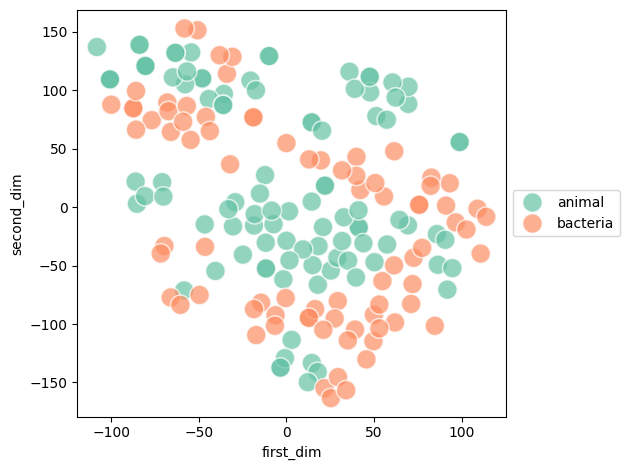

In [117]:
labels = {
    'Homo sapiens': 'animal',
    'Pan paniscus': 'animal',
    'Pan troglodytes': 'animal',
    'Tursiops truncatus': 'animal',
    'Hydrochoerus hydrochaeris': 'animal',
    'Escherichia coli': 'bacteria',
    'Pseudomonas aeruginosa': 'bacteria',
    'Lactobacillus acidophilus': 'bacteria',
    'Salmonella enterica': 'bacteria',
    }

embeddings_tsne_df['label'] = embeddings_tsne_df['organism'].map(labels)

ax = sns.scatterplot(data=embeddings_tsne_df,
                x='first_dim',
                y='second_dim',
                hue='label', color=None,
                s=200, alpha=0.7, palette='Set2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

Похоже, что, хотя последовательности животных и бактерий, как правило, занимают несколько разные части пространства встраивания, безусловно, существует много совпадений, предполагающих, что геномы на древе жизни имеют много общего!

**Вопрос**: Это то, что вы ожидали увидеть?

На случай, если вам интересно узнать больше о геномах животных и бактерий, вот несколько забавных фактов:
- ***Сходства***:
   **Базовый генетический код**: геномы животных и бактерий используют один и тот же генетический код, при этом последовательности ДНК состоят из одних и тех же четырех нуклеотидов: аденина (A), цитозина (C), гуанина (G) и тимина (T).
  - **Консервативные гены**: Многие фундаментальные гены, участвующие в важнейших процессах, таких как репликация ДНК, транскрипция и трансляция, сохраняются как у животных, так и у бактерий.
- ***Различия***:
  - **Размер генома**: Геномы животных обычно намного больше (у людей 3,2 миллиарда оснований ДНК), в то время как геномы бактерий меньше (от нескольких сотен тысяч до нескольких миллионов).
   **Хромосомы**: Животные имеют несколько линейных хромосом, в то время как бактерии обычно имеют одну кольцевую хромосому.
  - **Плотность генов**: Геномы бактерий более насыщены генами, в то время как геномы животных более разрежены и содержат больше регуляторных элементов.
  - **Структура гена**: Гены животных часто содержат интроны (некодирующие области внутри генов), в то время как гены бактерий обычно этого не делают.

**Вопрос**: Какие из этих различий могут быть отражены приведенными выше встраиваниями?

### **Вопрос**: 
Какие из этих различий могут быть отражены приведенными выше встраиваниями?

Учитывая что нелинейное преобразование, такое как, сводит высокоразмерное пространство к двумерному, где неизбежно происходит утрата линейной независимости, поскольку любые более чем два вектора в R^2 линейнозависимы. И тот факт что скалярным поизведением эмбидинга на маску мы преобразуем векторы в скаляры. Я надеюсь что сохранение локальной топологии обеспечивает достаточно дочную визуализацию кластеров, отражающих биологически значимые сходства. 

## **Задание**:
- Попробуйте получить некоторые последовательности ДНК для других видов, например, для некоторых видов растений. Вот несколько научных названий растений.:
```python
 plants = [
  'Oryza sativa',  # Rice
  'Vitis vinifera',  # Grape
  'Rosa chinensis',  # Rose
  'Musa acuminata',  # Banana
  'Solanum lycopersicum', # Tomato
 ]
 ```
- Насколько точечная диаграмма чувствительна к изменениям в случайных началах или других настройках? Попробуйте другой метод уменьшения размерности, например UMAP, вместо tSNE. Точечная диаграмма выглядит иначе?

In [ ]:
NUM_SEQUENCES = 200
MIN_LENGTH = 100
MAX_LENGTH = 1000
random.seed(42)

plants = [
    'Oryza sativa',  # Rice
    'Vitis vinifera',  # Grape
    'Rosa chinensis',  # Rose
    'Musa acuminata',  # Banana
    'Solanum lycopersicum',  # Tomato
]

target_organisms = plants[2:4]

print(f'Выборка {NUM_SEQUENCES} случайной последовательности ДНК минимальной длины '
      f'{MIN_LENGTH} и максимальной длины {MAX_LENGTH} для {len(target_organisms)} '
      'организмов...\n')

dna_sequences_df = []
organism_labels = []

for organism in tqdm.tqdm(target_organisms, desc='Организмы'):
  print(organism, flush=True)
  sequences = fetch_random_dna(
      organism, min_length=MIN_LENGTH, max_length=MAX_LENGTH,
      num_sequences=NUM_SEQUENCES)
  dna_sequences_df += sequences
  organism_labels += [organism] * len(sequences)

dna_sequences_df = pd.DataFrame({'sequence': dna_sequences_df, 'organism': organism_labels})

Выборка 200 случайной последовательности ДНК минимальной длины 100 и максимальной длины 1000 для 2 организмов...



Организмы:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

Rosa chinensis


In [ ]:
dna_sequences_df

In [140]:
embeddings = compute_mean_sequence_embeddings(
    dna_sequences_df['sequence'], tokenizer, language_model)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


In [141]:
embeddings.shape

(2, 512)

In [135]:
# Определяем число физических ядер с помощью wmic или используем логические ядра, если не удалось.
import multiprocessing
try:
    output = subprocess.check_output(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        text=True
    ).strip()
    lines = output.splitlines()
    # Пропускаем заголовок и суммируем количество ядер по всем CPU.
    num_cores = sum(int(line.split(',')[-1]) for line in lines[1:] if line)
except Exception as e:
    num_cores = multiprocessing.cpu_count()

# Устанавливаем переменную окружения для Loky
os.environ["LOKY_MAX_CPU_COUNT"] = str(num_cores)
print("Using", num_cores, "CPU cores (LOKY_MAX_CPU_COUNT).")
#__________________________________________________________________________
tsne = TSNE(n_components=2, learning_rate='auto', random_state=0, perplexity=1)
embeddings_tsne = tsne.fit_transform(embeddings)

embeddings_tsne_df = pd.DataFrame(
    embeddings_tsne, columns=['first_dim', 'second_dim'])

embeddings_tsne_df['organism'] = dna_sequences_df['organism']
embeddings_tsne_df

Using 8 CPU cores (LOKY_MAX_CPU_COUNT).


,first_dim,second_dim,organism
0,1523.730225,-2.365082e-11,Vitis vinifera
1,-1523.730225,-2.365082e-11,Musa acuminata


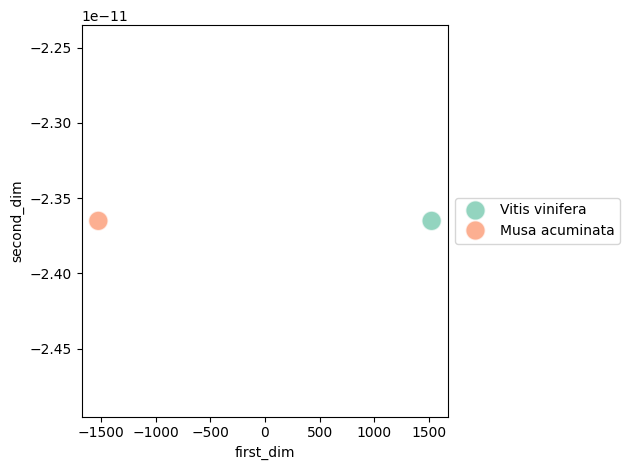

In [136]:
ax = sns.scatterplot(data=embeddings_tsne_df,
                x='first_dim',
                y='second_dim',
                hue='organism', color=None,
                s=200, alpha=0.7, palette='Set2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

## 3. Точная настройка языковой модели ДНК

В этом заключительном разделе мы будем адаптировать нашу языковую модель ДНК к новой задаче путем **тонкой настройки**.

### Что такое тонкая настройка (Fine-tuning)?
Точная настройка - это процесс использования **предварительно обученной модели** и внесения небольших корректировок, чтобы она могла выполнять новую, специализированную задачу.

Вместо того чтобы обучать модель с нуля, что может занять очень много времени и потребовать большого количества данных, мы начинаем с модели, которая уже понимает некоторые общие концепции. Затем мы продолжим обучение на меньшем наборе данных для конкретной задачи.

**Предварительное обучение с последующей точной настройкой** - это общая схема машинного обучения. Вот несколько примеров из естественного языка и языка ДНК:


<a href="https://ibb.co/tpd50VH"><img src="https://i.ibb.co/CKrFjRw/ML-for-bio-06.png" alt="NLP vs DNA" border="0" width="400"></a>


### Биологическая проблема

--> **Мы будем обучать модель предсказывать, будет ли данная цепочка из 200 оснований ДНК связывать данный фактор транскрипции**.

Факторы транскрипции (TFS) - это особые белки, которые связываются с ДНК и играют решающую роль в включении или выключении генов.  Они необходимы, поскольку контролируют экспрессию генов, которая, в свою очередь, влияет на то, как клетки функционируют, развиваются и реагируют на окружающую среду. Например, они могут определить, становится ли клетка мышечной клеткой, нейроном или клеткой кожи.

Вот изображение фактора транскрипции (фиолетовый), связывающегося с определенной областью ДНК (выделено желтым).:

<div align="center">
    <img src="https://www.nichd.nih.gov/sites/default/files/2022-05/TranscriptionFactor-400px.jpg" alt="DNA TF binding" width="400">
</div>






Каждый фактор транскрипции имеет определенное **предпочтение связывания** - он предпочитает связываться с определенной последовательностью оснований ДНК, а не с другими. Это связано с тем, что трехмерные формы TF и области ДНК могут хорошо сочетаться друг с другом.

У людей более 1000 факторов транскрипции. Мы рассмотрим специфический фактор транскрипции, называемый CTCF, который имеет тенденцию связываться с последовательностями, подобными CCACCAGGGGGGCGC (с некоторыми вариациями, допустимыми в некоторых положениях).

Вот задача прогнозирования в наглядном виде:


- Для конкретной цепочки из 200 пар оснований ДНК мы хотим предсказать вероятность того, что данный **фактор транскрипции** будет связываться в этом регионе.


## Набор данных

Набор данных, который мы будем использовать, выглядит следующим образом:

<a href="https://ibb.co/1ZbY3SF"><img src="https://i.ibb.co/PxtsRSq/ML-for-bio-05.png" alt="dataset description" border="0"></a>

Задача представляет собой ** задачу бинарной классификации ** – учитывая 200 оснований ДНК, мы предсказываем, будет ли она связывать определенный фактор транскрипции, называемый CTCF. CTCF на самом деле является особенно интересным фактором транскрипции, потому что он участвует в ** архитектуре генома **, или сложном трехмерном сворачивании генома в определенные компартменты.

Проблема навеяна одной из задач оценки в этом недавнем [2024 paper preprint](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10925287/), который получил набор данных из этого [2023 genomics interpretation paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10169356/)

#### Загрузка набора данных.

Обучающий набор данных уже создан для вас:
- У нас есть 20000 обучающих примеров.
- Каждый из них представляет собой среднее встраивание ДНК, которое было извлечено с использованием языковой модели NT.
- Последний столбец фрейма данных - это метка, независимо от того, связывает ли ДНК белок CTCF или нет

In [ ]:
train_df

В целом, похоже, что 2 класса достаточно сбалансированы (одинаково представлены) в обучающем наборе данных, что означает, что нам не нужно будет выполнять здесь какую-либо перебалансировку:

In [ ]:
train_df['label'].value_counts()

Если вам интересно, вы можете взглянуть на код, описывающий, как был сгенерирован этот набор данных, но вам не нужно запускать его здесь.

#### [Вам не нужно запускать этот] Код создания набора данных.

```python
# 1. Загрузите файл h5, содержащий наборы данных CTCF.
file_path = os.path.join(ROOT_DIR, 'CTCF_200.h5')

with h5py.File(file_path, 'r') as h5file:
  print("Keys: %s" % list(h5file.keys()))

  # Получите доступ к каждому набору данных и преобразуйте его в массивы numpy.
  x_train = h5file['x_train'][()]
  y_train = h5file['y_train'][()]
  x_valid = h5file['x_valid'][()]
  y_valid = h5file['y_valid'][()]
  x_test = h5file['x_test'][()]
  y_test = h5file['y_test'][()]

# Каждая последовательность ДНК имеет кодировку one-hot. Визуализируйте первый обучающий пример.:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(x_train[0, :, :])
plt.show()

# 2. Поскольку наша языковая модель ДНК фактически принимает буквы в качестве входных данных, мы можем отменить
# одноразовое кодирование с помощью функции:

def one_hot_to_dna_batch(one_hot_encoded_batch: np.ndarray):
  """
  Преобразуйте пакет однократно закодированных последовательностей ДНК обратно в строки последовательностей ДНК.

  Аргументы:
    one_hot_encoded_batch (numpy.ndarray): трехмерный массив numpy с кодированием one-hot
      последовательности ДНК. Форма должна быть (num_sequences, sequence_length, 4).

  ВОЗВРАТ:
    список: Список последовательностей ДНК.
  """
  # Определите отображение от одноразового кодирования к нуклеотидам.
  one_hot_mapping = {
      (1, 0, 0, 0): 'A',
      (0, 1, 0, 0): 'C',
      (0, 0, 1, 0): 'G',
      (0, 0, 0, 1): 'T',
  }

  dna_sequences = []

  for one_hot_encoded in one_hot_encoded_batch:
    dna_sequence = []
    for one_hot in one_hot_encoded:
      one_hot_tuple = tuple(one_hot)
      dna_sequence.append(one_hot_mapping[one_hot_tuple])

    dna_sequences.append(''.join(dna_sequence))

  return dna_sequences

NUM_TRAIN_EXAMPLES = 20_000
NUM_VALID_EXAMPLES = 5_000

x_train = one_hot_to_dna_batch(
    np.moveaxis(x_train, 1, -1)[0:NUM_TRAIN_EXAMPLES])
y_train = y_train[0:NUM_TRAIN_EXAMPLES]

x_valid = one_hot_to_dna_batch(
    np.moveaxis(x_valid, 1, -1)[0:NUM_VALID_EXAMPLES])
y_valid = y_valid[0:NUM_VALID_EXAMPLES]

# Взгляните на обучающие примеры и ярлыки:
print(x_train[0:5])
print(y_train[0:5])

# 3. Вычислите средние вложения последовательностей в языковую модель ДНК.
train_embeddings = compute_mean_sequence_embeddings(
    x_train, tokenizer, language_model)
train_df = pd.DataFrame(train_embeddings)
train_df['label'] = y_train[:, 0]

valid_embeddings = compute_mean_sequence_embeddings(
    x_valid, tokenizer, language_model)
valid_df = pd.DataFrame(valid_embeddings)
valid_df['label'] = y_valid[:, 0]
```

## Преобразуйте данные в набор данных TensorFlow

Нам нужно будет преобразовать эти фреймы данных в набор данных TensorFlow, который мы можем легко использовать при обучении модели:

In [ ]:
import tensorflow as tf
import numpy as np

def convert_to_tfds(df: pd.DataFrame, batch_size: int=32,
                    is_training: bool=False):
    """Преобразуйте вложения и метки в набор данных TensorFlow."""
    embeddings = np.array(df.iloc[:, :-1])
    labels = np.array(df.iloc[:, -1])[:, None]

    ds = tf.data.Dataset.from_tensor_slices(
        {'embeddings': embeddings, 'labels': labels})

    if is_training:
      ds = ds.shuffle(buffer_size=len(df)).repeat()

    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return iter(ds)

BATCH_SIZE = 32

train_ds = convert_to_tfds(
    train_df, batch_size=BATCH_SIZE, is_training=True)
valid_ds = convert_to_tfds(
    valid_df, batch_size=BATCH_SIZE, is_training=False)

Давайте взглянем на один обучающий пакет данных:

In [ ]:
batch = next(train_ds)
batch

Весь набор данных подготовлен для обучения модели!

## Точная настройка модели


Теперь мы будем обучать простую линейную модель [flax](https://flax.readthedocs.io/en/latest/) поверх средних вложений ДНК.

Flax очень похож на многие другие фреймворки глубокого обучения (особенно [Haiku](https://dm-haiku.readthedocs.io/en/latest/), если вы с ним сталкивались). В нашей настройке обратите внимание, что наша модель представляет собой всего лишь MLP (многослойный персептрон, представляющий собой несколько линейных слоев с некоторыми нелинейностями) – мы не модифицируем (возвращаемся к) исходную языковую модель ДНК.

In [ ]:
class Model(nn.Module):
  dim: int = 128

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(self.dim * 2)(x)
    x = nn.gelu(x)
    x = nn.Dense(self.dim)(x)
    x = nn.gelu(x)
    x = nn.Dense(1)(x)
    return x

In [ ]:
mlp = Model()

### Тренировочный цикл

Настроив модель и данные, мы теперь можем инициализировать параметры нашей модели, наш оптимизатор и написать функцию для выполнения одного шага обучения (который включает в себя прямой проход модели, вычисление потерь, вычисление градиента и обновление параметров модели с использованием градиентов):

In [ ]:
LEARNING_RATE = 0.0001

init_rng = jax.random.PRNGKey(42)
variables = mlp.init(init_rng, batch['embeddings'])
params = variables['params']

optimiser = optax.adam(LEARNING_RATE)
opt_state = optimiser.init(params)

Вы можете ознакомиться с названиями слоев в нашей нейронной сети следующим образом:

In [ ]:
params.keys()

И убедитесь, что форма этого слоя соответствует вашим ожиданиям, например, так:

In [ ]:
for layer_name in ['Dense_0', 'Dense_1', 'Dense_2']:
  print(params[layer_name]['kernel'].shape)

### **Вопрос**: 
Можете ли вы выяснить, откуда берутся эти формы, учитывая наш код в нашей `class Model` выше?

Мы уже могли бы делать прогнозы, используя эти случайно инициированные параметры (просто прогнозы будут случайными).:

In [ ]:
preds = mlp.apply({'params': params}, batch['embeddings'])
nn.sigmoid(preds)

Давайте теперь определим функцию потерь, которую мы можем использовать для обучения этих параметров:

In [ ]:
def loss_fn(params, embeddings, labels):
  """Применяет сигмоид к логитам и вычисляет потери двоичной кросс-энтропии."""
  logits = mlp.apply({'params': params}, embeddings)
  loss = optax.sigmoid_binary_cross_entropy(
      logits=logits, labels=labels).mean()
  return loss

Давайте вычислим пример потерь:

In [ ]:
embeddings = jnp.array(batch['embeddings'])
labels = jnp.array(batch['labels'])
loss_fn(params, embeddings, labels)

Итак, мы ожидаем потери примерно в диапазоне 0,6-0,7 для случайно инициализированных весов. Надеюсь, при обучении модели мы увидим потери меньшие, чем эти, поскольку модель изучает сигнал в данных! :)

Наконец, мы можем написать обучающую пошаговую функцию:

In [ ]:
@jax.jit
def train_step(params, opt_state, embeddings, labels):
  """Единый шаг обучения, который вычисляет градиенты и обновляет параметры модели."""
  loss, grads = jax.value_and_grad(loss_fn)(params, embeddings, labels)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

### Давайте обучим модель!

In [ ]:
NUM_EPOCHS = 5
NUM_TRAINING_STEPS = (len(train_df) // BATCH_SIZE) * NUM_EPOCHS
LEARNING_RATE = 0.001

# Повторно инициализируйте модель, чтобы убедиться, что мы начинаем заново при каждом запуске ячейки.
init_rng = jax.random.PRNGKey(42)
variables = mlp.init(init_rng, batch['embeddings'])
params = variables['params']

optimiser = optax.adam(LEARNING_RATE)
opt_state = optimiser.init(params)

# Ведите учет потерь.
running_train_loss = None
running_train_losses = []
valid_losses = []

for epoch in tqdm.tqdm(range(NUM_EPOCHS)):

  # Тренировочный цикл.
  for step in range(NUM_TRAINING_STEPS):
    batch = next(train_ds)
    embeddings = jnp.array(batch['embeddings'])
    labels = jnp.array(batch['labels'])
    params, opt_state, loss = train_step(params, opt_state, embeddings, labels)

    if running_train_loss is None:
      running_train_loss = loss.item()
    else:
      running_train_loss = 0.99 * running_train_loss + (1 - 0.99) * loss.item()
    running_train_losses.append(running_train_loss)

  # Цикл проверки.
  valid_ds = convert_to_tfds(valid_df, batch_size=BATCH_SIZE, is_training=False)
  for batch in valid_ds:
    embeddings = jnp.array(batch['embeddings'])
    labels = jnp.array(batch['labels'])
    loss = loss_fn(params, embeddings, labels)
    valid_losses.append(loss.item())

  valid_loss = np.mean(valid_losses)
  print(f'[Epoch {epoch}]: Valid loss={valid_loss:.3f}, '
        f'Train loss={running_train_loss:.3f}\n')

print('Обучение завершено!!!')

🎉🎉 **И мы закончили с базовым обучением модели!** 🎉🎉

## Проверка модели на работоспособность

Мы можем попробовать вывести обученную модель из любой новой цепочки ДНК, представляющей интерес. Например, поскольку из биологических экспериментов мы знаем, что белок CTCF связывается с последовательностями ДНК, содержащими мотивы, подобные "CCACCAGGGGGGCGC", то модель должна предсказывать очень высокую вероятность связывания ДНК, содержащей эти мотивы.

Давайте построим цепочку ДНК длиной в 200 оснований и возьмем ее встраивание:

In [ ]:
ctcf_motif_dna = 'CCACCAGGGGGCGC'*14 + 'AAAA'
print('Длина цепочки ДНК, заполненной мотивом CTCF:', len(ctcf_motif_dna))

ctcf_motif_embedding = compute_mean_sequence_embeddings(
    [ctcf_motif_dna], tokenizer, language_model)

Теперь мы можем вычислить вероятность того, что ДНК свяжет CTCF:

In [ ]:
jax.nn.sigmoid(mlp.apply({'params': params}, ctcf_motif_embedding))

Успех! Эта вероятность очень близка к 1. Это означает, что модель научилась идентифицировать некоторое представление этого мотива и связывать его со связыванием CTCF с ДНК.

И наоборот, случайные цепочки ДНК должны иметь низкую вероятность связывания CTCF:

In [ ]:
%%capture
random_dna_strings = [
    'ACGTACGT'*25,
    'CGGCCGCG'*25,
    'TCGATCGT'*25,
    'TTTTTTTT'*25,
]

probabilities = []

for random_dna_string in random_dna_strings:
  random_dna_embedding = compute_mean_sequence_embeddings(
    [random_dna_string], tokenizer, language_model)

  probabilities.append(
      jax.nn.sigmoid(mlp.apply({'params': params}, random_dna_embedding))[0])

In [ ]:
probabilities

Отлично, все это выглядит как вероятность, близкая к нулю, чего мы и ожидали 😎.

## [Необязательные последующие действия]

1. **[Построение графика потерь]** Попробуйте построить график потерь при обучении и проверке с течением времени. Что вы видите? Должны ли мы тренировать его дольше? Есть ли переобучение в тренировочном наборе? Если да, то как вы могли бы улучшить ситуацию?
 - **Подсказка**: попробуйте `plt.plot(train_losses, c = 'grey')`.
2. **[Показатели оценки]** До сих пор мы отслеживали потери только во время обучения модели, но их немного сложно интерпретировать. Как вы могли бы реализовать и отслеживать показатель **точности** во время обучения?
 - **Подсказка**: Помните, что если вы укажете jax.nn.sigmoid на предсказания модели, это даст вероятность того, что последовательность ДНК связывает белок CTCF. Вы могли бы рассматривать любую вероятность выше 0,5 как предсказание "1", а любую вероятность ниже 0,5 - как предсказание "0".
3. **[Настройка гиперпараметров]** Попробуйте изменить скорость обучения, размер пакета и количество шагов обучения. Как эти изменения влияют на сходимость и конечную производительность модели?
4. **[Расширение данных]** Можете ли вы придумать способ расширить (или дополнить) обучающий набор? Как бы вы оценили, полезно ли это для производительности модели?
5. **[Разные архитектуры]** Поэкспериментируйте с различными архитектурами моделей, например, добавьте больше слоев или используйте различные функции активации.
 - **Задача**: если вы чувствуете себя очень предприимчивым, попробуйте внедрить CNN, который может учиться непосредственно на последовательностях ДНК (кодируемых одним нажатием кнопки)!
